# Comparing the metrics of different Scikit-Learn models

One of the most important things when comparing different models is to make sure they're compared on the same data splits.

For example, let's say you have `model_1` and `model_2` which each differ slightly.

If you want to compare and evaluate their results, `model_1` and `model_2` should both be trained on the same data (e.g. `X_train` and `y_train`) and their predictions should each be made on the same data, for example:
* `model_1.fit(X_train, y_train)` -> `model_1.predict(X_test)` -> `model_1_preds`
* `model_2.fit(X_train, y_train)` -> `model_2.predict(X_test)` -> `model_2_preds`

Note the differences here being the two models and the 2 different sets of predictions which can be compared against each other.

This short notebook compares 3 different models on a small dataset.
1. A baseline `RandomForestClassifier` (all default parameters)
2. A `RandomForestClassifier` tuned with `RandomizedSearchCV` (and `refit=True`)
3. A `RandomForestClassifier` tuned with `GridSearchCV` (and `refit=True`)

The most important part is they all use the same data splits created using `train_test_split()` and `np.random.seed(42)`.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

## Import and split data


In [2]:
heart_disease = pd.read_csv("https://raw.githubusercontent.com/mrdbourke/zero-to-mastery-ml/master/data/heart-disease.csv")

# Split into X & y
X = heart_disease.drop("target", axis =1)
y = heart_disease["target"]

# Split into train & test
np.random.seed(42) # seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Make evaluation function

Our evaluation function will use all of the major classification metric functions from Scikit-Learn.

In [3]:
def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

## Baseline model
Create model with default hyperparameters. See [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) documentation for more.

In [4]:
np.random.seed(42)

# Make & fit baseline model
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make baseline predictions
y_preds = clf.predict(X_test)

# Evaluate the classifier on validation set
baseline_metrics = evaluate_preds(y_test, y_preds)

Acc: 83.61%
Precision: 0.84
Recall: 0.84
F1 score: 0.84


## RandomizedSearchCV
Find hyperparameters with [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Note:** Although best parameters are found on different splits of `X_train` and `y_train`, because `refit=True`, once the best parameters are found, they are refit to the entire set of `X_train` and `y_train`. See the [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) and [cross-validation documentation](https://scikit-learn.org/stable/modules/cross_validation.html) for more.

In [5]:
from sklearn.model_selection import RandomizedSearchCV

# Setup the parameters grid
grid = {"n_estimators": [10, 100, 200, 500, 1000, 1200],
        "max_depth": [None, 5, 10, 20, 30],
        "max_features": ["auto", "sqrt"],
        "min_samples_split": [2, 4, 6],
        "min_samples_leaf": [1, 2, 4]}

# Instantiate RandomForestClassifier
clf = RandomForestClassifier(n_jobs=1)

# Setup RandomizedSearchCV
rs_clf = RandomizedSearchCV(estimator=clf,
                            param_distributions=grid, 
                            n_iter=10, # number of models to try
                            cv=5,
                            verbose=2,
                            random_state=42, # set random_state to 42 for reproducibility
                            refit=True) # set refit=True (default) to refit the best model on the full dataset 

# Fit the RandomizedSearchCV version of clf
rs_clf.fit(X_train, y_train) # 'rs' is short for RandomizedSearch

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimato

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=1),
                   param_distributions={'max_depth': [None, 5, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [10, 100, 200, 500,
                                                         1000, 1200]},
                   random_state=42, verbose=2)

In [6]:
# Check best parameters of RandomizedSearchCV
rs_clf.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 30}

In [7]:
# Evaluate RandomizedSearch model
rs_y_preds = rs_clf.predict(X_test)

# Evaluate the classifier on validation set
rs_metrics = evaluate_preds(y_test, rs_y_preds)

Acc: 85.25%
Precision: 0.85
Recall: 0.88
F1 score: 0.86


## GridSearchCV
Find best hyperparameters using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

**Note:** Although best parameters are found on different splits of `X_train` and `y_train`, because `refit=True`, once the best parameters are found, they are refit to the entire set of `X_train` and `y_train`. See the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [cross-validation documentation](https://scikit-learn.org/stable/modules/cross_validation.html) for more.

In [8]:
from sklearn.model_selection import GridSearchCV

# Setup grid-2 (refined version of grid)
grid_2 = {'n_estimators': [50, 100, 150],
          'max_depth': [30, None],
          'max_features': ['auto', 'sqrt'],
          'min_samples_split': [2],
          'min_samples_leaf': [1, 2, 4]}

# Instantiate RandomForestClassifier
clf = RandomForestClassifier(n_jobs=1)

# Setup GridSearchCV
gs_clf = GridSearchCV(estimator=clf,
                      param_grid=grid_2, 
                      cv=5,
                      verbose=2,
                      refit=True) # set refit=True (default) to refit the best model on the full dataset

# Fit the GridSearchCV version of clf
gs_clf.fit(X_train, y_train) # 'gs' is short for GridSearch

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; to

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=1),
             param_grid={'max_depth': [30, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2],
                         'n_estimators': [50, 100, 150]},
             verbose=2)

In [9]:
# Find best parameters of GridSearchCV
gs_clf.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 50}

In [10]:
# Evaluate GridSearchCV model
gs_y_preds = gs_clf.predict(X_test)

# Evaluate the classifier on validation set
gs_metrics = evaluate_preds(y_test, gs_y_preds)

Acc: 86.89%
Precision: 0.85
Recall: 0.91
F1 score: 0.88


## Compare metrics
Compare all of the found metrics between the models.

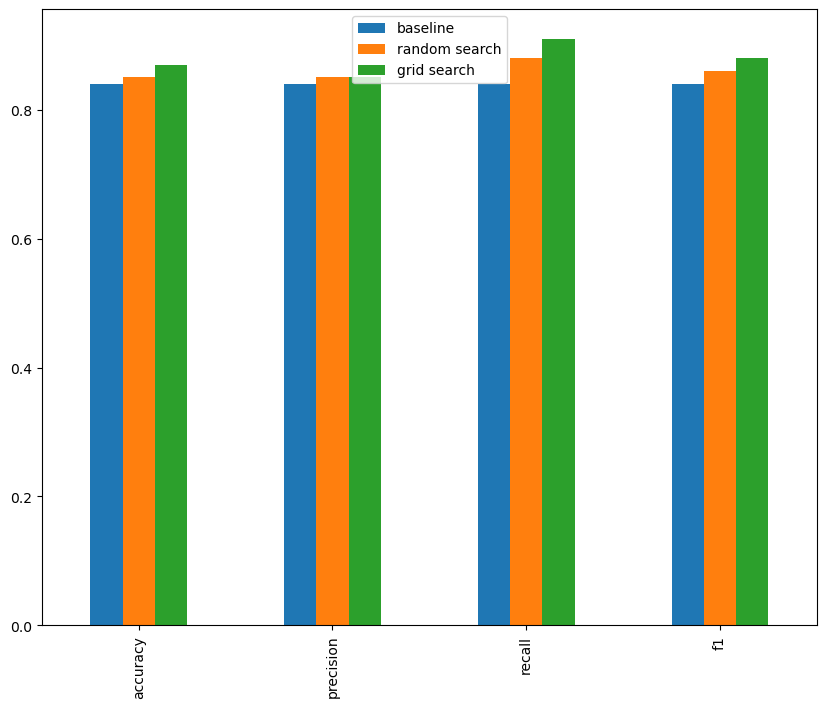

In [11]:
compare_metrics = pd.DataFrame({"baseline": baseline_metrics,
                                "random search": rs_metrics,
                                "grid search": gs_metrics})

compare_metrics.plot.bar(figsize=(10, 8));